## 更好的降维算法
上一讲里我们简单介绍了聚类方法和简单的线性降维方法(PCA、LDA)，我们还讲了AutoEncoder。但是在实际使用时，我们经常发现，因为LDA和PCA不能实现非线性降维，它们在实际场景中不总能取得好的效果。而AE虽然能实现非线性，但它需要一段可能不短的训练时间开销，而且它给出的解并不稳定(会根据初始化的值变化)。我们也许需要更好的，既能实现非线性，又能学习流形，还能保证运行速度的算法。  
t-SNE被称为现在最好的降维算法，我们就将围绕它来展开讲一下这个东西是如何运作的。

### LLE
首先讲一下基于线性近邻的降维学习方法，这个方法叫Locally Linear的Embeddding。虽然它的名字是linear，但其实实现的是非线性的降维。为什么叫Locally Linear呢？这个名字就是算法的精髓，我们对原数据降维后，保有的是样本点和它附近的k个样本点的固有线性关系。如果原空间的x0附近的3近邻是x1,x2,x3，而且原空间中有x0 = 0.5x1+0.25x2+0.25x3的线性关系，那么我们希望降维后，这个关系仍然存在。  
那么，算法最首要的任务就是求解每个数据点的k近邻，并计算上面的线性组合权重向量w。事实上，k近邻的线性组合并不保证能完全等于数据点x，所以我们实质上要解的是一个优化问题。写出优化问题，如下式(x默认为行向量)
$$ minimize \qquad \sum_{i=1}^M ||x_i-\sum_{j\in Q_i}w_{ij}x_j||^2 $$
如果我们把所有k近邻的xj行向量在列方向上排列成矩阵，wi是样本点xi对于的权重向量，则上式有矩阵代数形式
$$ minimize \qquad \sum_{i=1}^M ||x_i-w_i X_{Q_i}||^2 $$
求和号中的每项都是独立的优化问题，我们对其中任意i的一项求偏导为0
$$ (w_i X_{Q_i}-x_i)X_{Q_i}^T  = 0 $$
$$ w_i = x_i X_{Q_i}^T(X_{Q_i}X_{Q_i}^T)^{-1} $$
按照上式可以解出所有的$w_{ij}$(不属于k近邻的$j$权重$w_{ij}$就设为0)，然后我们的问题就变成了从W矩阵重构一个低维的数据集矩阵Z，其中$z_{i}$是Z矩阵的第i行，表示原数据点$x_i$降维后的结果。我们的设降维后的Z高为n，宽为d，即降维的目标维度。优化问题和上面的形式实质上是类似的，不过我们现在希望求解Z
$$ minimize \qquad \sum_{i=1}^M ||z_i-w_i Z||^2 $$
同样可以写成更代数的形式
$$ minimize \qquad tr[(Z- WZ)^T(Z- WZ)] = tr[Z^T(I- W)^T(I- W)Z] $$
如果不加约束，上式解出来的Z只会非常非常小，甚至等于0.为了得到有效的解我们还要加一些约束
$$ s.t.\qquad Z^TZ = I $$
然后这个形式就和PCA类似了，我们对$M=(I- W)^T(I- W)$做特征值分解，并取最小的特征值，就得到了Z，降维后的数据。
$$ L(Z) = tr[Z^TMZ]-\lambda (Z^TZ - I) $$
$$\frac{\partial{L}}{\partial{Z}} = MZ-\lambda Z = 0 $$
$$ M z_i = \lambda z_i $$

In [1]:
import numpy as np
import random
from copy import deepcopy
import matplotlib
from matplotlib import pyplot as plt 
from sklearn.metrics import accuracy_score
import warnings
from sklearn import datasets

In [7]:
def dist(x1,x2):
    '''
    x1,x2: numpy array, shape1 = (m，), shape2 = (m，)
    表示维度都为m的两个向量
    return: D，int, 表示数据点差异的L2范数
    '''
    return np.sum((x1-x2)**2)

def LLE(X, k, d):
    '''
    X: numpy array, shape = (n,m)，表示n个m维的数据点组成的数据集
    k: LLE使用k近邻，不得大于n-1
    d: 目标降维维度，小于m大于0
    return: Z，numpy array, shape = (n,d)，表示n个d维的数据点组成的数据集
    '''
    n,m = X.shape
    D = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            D[i][j] = dist(X[i],X[j])     #得到L2的距离矩阵
    
    knn = []
    for i in range(n):
        knn.append(np.argsort(D[i])[1:k+1]) #得到每个点的k近邻
    
    W = np.zeros((n,n))
    for i in range(n):
        XQ = X[knn[i]]                # K近邻矩阵
        A = XQ.dot(XQ.T)
        A+=np.eye(k)*1e-3*np.trace(XQ)  #magic,保证正定
        W[i][knn[i]] = X[i].dot(XQ.T).dot(np.linalg.pinv(A))
        # 得到局部线性嵌入权重矩阵
    
    M = (np.eye(n)-W).T.dot((np.eye(n)-W))  # 计算M矩阵
    lamda,V=np.linalg.eigh(M)
    # 取前dim个最小的特征值对应的特征向量
    index=np.argsort(lamda)[:d]
    V_selected=V[:,index]
    return V_selected

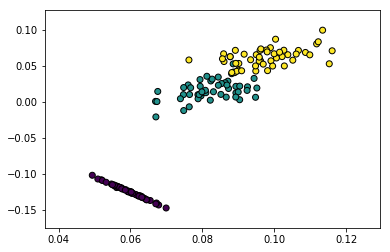

In [8]:
X,y = datasets.load_iris(return_X_y=True)

Z = LLE(X,25,2)
plt.scatter(Z[:,0], Z[:,1],edgecolors='black',c=y)

C:\anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


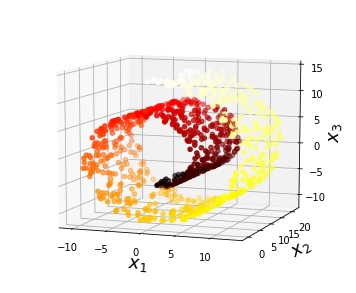

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
#Generate mainfold data set
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0, random_state=0)
axes = [-11.5, 14, -2, 23, -12, 15]
#plot figure
fig = plt.figure(figsize=(6, 5))
plt.title("old_data", fontsize=14)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

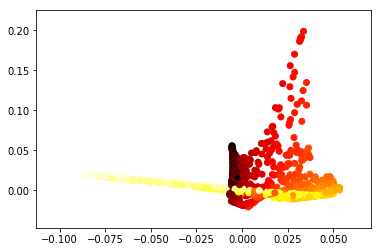

In [11]:
Z = LLE(X,k=6,d=2)
plt.scatter(Z[:, 0], Z[:, 1], c=t, cmap=plt.cm.hot)
plt.show()

### Isomap
上面的LLE算法，劣势在于我们用于重建Z的W矩阵，只包含近邻点的信息；很直觉地可以想到，如果上级算法不提供给我们它与其他非近邻点的关系信息，算法很显然不能稳定地给出近邻的点仍然近邻，远离的点仍然远离的结果。  
以上面的流形问题为例，我们在这种模型中希望用测地线距离替换原空间的欧拉距离。修过图论或者数据结构的都知道，如果我们把数据点看做图中的顶点，则我们是有比较高效的算法计算任意两点间在图中的最短距离的(Floyd or dijkstra)。这样我们就得到了一种能近似测地线距离的新距离矩阵。这个矩阵提供了哪些点离得近，哪些点离得远的全部信息。 
### MDS
从距离矩阵重构数据点信息需要MDS算法。首先我们认为这个距离矩阵在重构后的空间Z中表现出的是两点间的欧拉距离，如果我们设$b_{ij} = z_i^Tz_j $，限制Z，认为Z的均值为0。就有$ dist_{ij}^2 = ||z_i||^2+||z_j||^2-2z_i^Tz_j = b_{ii}+b_{jj}-2b_{ij} $且$ \sum_{i=1}^n b_{ij} = \sum_{j=1}^n b_{ij} = 0 $。则如果对上面的式子做类似"边缘积分"的运算，能得到一些有用的结论。
$$ \sum_{i=1}^ndist_{ij}^2 = tr(B)+nb_{jj} $$
$$ \sum_{j=1}^ndist_{ij}^2 = tr(B)+nb_{ii} $$
$$ \sum_{i=1}^ndist_{ij}^2\sum_{j=1}^n = 2ntr(B) $$
从这三个结论我们可以反推出，具有中心化性质的Z矩阵对应的内积矩阵B
$$ b_{ij} = -\frac{1}{2}(dist_{ij}^2-\frac{1}{n}\sum_{j=1}^n dist_{ij}^2-\frac{1}{n}\sum_{i=1}^n dist_{ij}^2+\frac{1}{n^2}\sum_{i=1}^n\sum_{j=1}^n dist_{ij}^2 $$
内积矩阵是$ B = ZZ^T $，可以用特征值分解来解Z。$ B = V\Lambda V^T $，则$ Z = V \Lambda^{\frac{1}{2}} $。我们取前d个特征向量和特征值，就得到了降维后的Z矩阵。

In [12]:
import heapq

def MDS(D,dim):
    m = len(D)
    disti_ = np.zeros(m)
    dist_j = np.zeros(m)
    dist__ = 0
    for i in range(m):
        disti_[i]=np.mean(D[i,:])
    for j in range(m):
        dist_j[j]=np.mean(D[:,j])
    dist__ = np.mean(D)
    B = np.copy(D)
    for i in range(m):
        for j in range(m):
            B[i][j] += (-disti_[i]-dist_j[j]+dist__)
            B[i][j] *= -0.5
    vals, vecs = np.linalg.eig(B)
    lamda,V=np.linalg.eigh(B)
    index=np.argsort(-lamda)[:dim]
    diag_lamda=np.sqrt(np.diag(-np.sort(-lamda)[:dim]))
    V_selected=V[:,index]
    Z=V_selected.dot(diag_lamda)
    return Z

def Isomap(X, k, dim):
    N = len(X)
    D = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            D[i][j] = dist(X[i],X[j])**0.5
            D[j][i] = D[i][j]
    
    bound = D.max()
    Map = np.ones((N,N))*1000
    n,m = X.shape
    
    for i in range(n):
        knn = np.argsort(D[i])[1:k+1] #得到每个点的k近邻
        Map[i,knn] = D[i,knn]
        Map[knn,i] = D[knn,i]
    #Floyd算法
    for k in range(N):
        for i in range(N):
            for j in range(N):
                Map[i][j] = min(Map[i][k]+Map[k][j],Map[i][j])
    
    
    Map[np.where(Map==1000)] = bound
    return MDS(Map,dim)

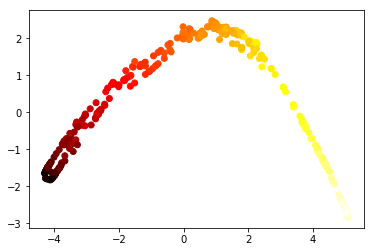

In [13]:
X, t = make_swiss_roll(n_samples=300, noise=0, random_state=0)
Z = Isomap(X,k=4,dim=2)
plt.scatter(Z[:, 0], Z[:, 1], c=t, cmap=plt.cm.hot)
plt.show()

虽然Isomap一般能比较完美地学习流形，但Isomap的劣势也非常明显，它必须花费O(n^3)的时间开销去计算距离矩阵，这比一般算法的O(n^2)要可怕很多。即使是在上面的1000级别的瑞士卷样本上跑一次都要花费相当多的时间。尽管我们可以用一些近似算法来做一些加速，但是这仍然不是一个高效的算法。

### SNE
stochastic neighbor embedding，事实上我们从上面的例子可以看出来，LLE解决的问题是"把原本就靠近的数据点相互靠近"，这可以在原始数据分布性质比较好，分布比较开的数据集上表现得不错。但是如果原始数据集的分布性质一般，像是上面的流形，算法的确会把近似的点都放在一起，但是并不保证不相似的点能分开。虽然LLE经过细致的调参可以在上面的流形跑出还不错的结果，但是这并非我们想要的。  
TSNE一定程度上解决的就是这个问题，它使用了概率和近似的方法，一般能得到高维到低维的比较好的效果。它也是当前最常被用作可视化工具的一种方法。

### 算法
这个算法基于距离，给出样本点的相似度概念；这个相似度还会被归一化成概率形式。
$$ P(x_j|x_i) = \frac{S(x_i,x_j)}{\sum_{k\neq i}S(x_i,x_k)} $$
$$ P(z_j|z_i) = \frac{S'(z_i,z_j)}{\sum_{k\neq i}S'(z_i,z_k)} $$
算法的优化目标是两个概率分布的KL散度
$$ L = \sum_i KL(P(*|x_i)||Q(*|z_i)) = \sum_i\sum_j P(x_j|x_i)log\frac{P(x_j|x_i)}{Q(z_j|z_i)} $$
SNE在相似度上使用的分布函数是高斯函数。
$$ P(x_j|x_i) = \frac{exp(-||x_i-x_j||^2/2\sigma_i^2)}{\sum_{k\neq i}exp(-||x_i-x_k||^2/2\sigma_i^2)} $$
想执行算法可能还需要先确定每个i对应的方差(高斯核带宽)，这个过程也是有方法做的。原始论文用的是perplexity的定义。我们用二分法找一个困惑度最小的方差
$$Perp(P_i) = 2^{H(P_i)}$$
$$ H(P_i) = -\sum_j p_{j|i}log_2 p_{j|i} $$
但是实际使用的时候，一般会在转换前的高维空间进行搜索，对低维直接用常数。确定了方差，一切就都可以计算了，我们可以用梯度下降来解这个问题
$$ \frac{\partial L} {\partial y_i} = 2\sum_j(p_{j|i}-q_{j|i}+p_{i|j}-q{i|j})(y_i-y_j) $$

### t-SNE
SNE的缺点是不容易优化，Hinton等人在08年提出了t-SNE这种变形。主要改动了以下两点。  
1. t-SNE在相似度上使用的分布函数是高斯函数和学生氏分布(t分布)。
$$ p_{i|j} = \frac{exp(-||x_i-x_j||^2/2\sigma_i^2)}{\sum_{k\neq i}exp(-||x_k-x_i||^2/2\sigma_i^2)} $$
$$ q_{i|j} = \frac{(1+||x_i-x_j||^{2})^{-1}}{\sum_{k\neq i}(1+||x_k-x_i||^{2})^{-1}} $$
因为t分布更有长期性，在新空间中可以表现得更好。
2. 这里的分布不再是条件概率分布，而是联合概率分布。同时提出假设，假设pij=pji。另外，为了柔和化异常点的影响，我们使用修正的概率计算梯度。
$$ p_{ij} = (p_{i|j}+p_{j|i})/2 $$
这时的梯度也有更为简单的形式。
$$ \frac{\partial L} {\partial y_i} = 4\sum_j(p_{ij}-q_{ij})(y_i-y_j)(1+||y_i-y_j||^2)^{-1} $$
讲的比较好的一篇:http://www.datakit.cn/blog/2017/02/05/t_sne_full.html

In [14]:
def cal_pairwise_dist(x):
    '''计算pairwise 距离, x是matrix
      (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist

# 计算困惑度，最终会选择合适的beta，也就是每个点的方差啦
def cal_perplexity(dist, idx=0, beta=1.0):
    # '''计算perplexity, D是距离向量，
    # idx指dist中自己与自己距离的位置，beta是高斯分布参数
    # 这里的perp仅计算了熵，方便计算
    # '''
    prob = np.exp(-dist * beta)
    # 设置自身prob为0
    prob[idx] = 0
    sum_prob = np.sum(prob)
    if sum_prob == 0:
        prob = np.maximum(prob, 1e-12)
        perp = -12
    else:
        prob /= sum_prob
        perp = 0
        for pj in prob:
            if pj != 0:
                perp += -pj*np.log(pj)
    # 困惑度和pi\j的概率分布
    return perp, prob

In [15]:
def seach_prob(x, tol=1e-5, perplexity=30.0):
    # '''二分搜索寻找beta,并计算pairwise的prob
    # '''
    # 初始化参数
    print("Computing pairwise distances...")
    (n, d) = x.shape
    dist = cal_pairwise_dist(x)
    pair_prob = np.zeros((n, n))
    beta = np.ones((n, 1))
    # 取log，方便后续计算
    base_perp = np.log(perplexity)

    for i in range(n):
        if i % 500 == 0:
            print("Computing pair_prob for point %s of %s ..." %(i,n))

        betamin = -np.inf
        betamax = np.inf
        #dist[i]需要换不能是所有点
        perp, this_prob = cal_perplexity(dist[i], i, beta[i])

        # 二分搜索,寻找最佳sigma下的prob
        perp_diff = perp - base_perp
        tries = 0
        while np.abs(perp_diff) > tol and tries < 50:
            if perp_diff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            # 更新perb,prob值
            perp, this_prob = cal_perplexity(dist[i], i, beta[i])
            perp_diff = perp - base_perp
            tries = tries + 1
        # 记录prob值
        pair_prob[i,] = this_prob
    print("Mean value of sigma: ", np.mean(np.sqrt(1 / beta)))
    #每个点对其他点的条件概率分布pi\j
    return pair_prob

In [16]:
def tsne(x, no_dims=2, initial_dims=50, perplexity=30.0, max_iter=800):
    """Runs t-SNE on the dataset in the NxD array x
    to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(x, no_dims, perplexity),
    where x is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array x should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    (n, d) = x.shape
    print (x.shape)

    #动量
    lr = 500
    # 随机初始化Y
    y = np.random.randn(n, no_dims)
    # dy梯度
    dy = np.zeros((n, no_dims))
    # 对称化
    P = seach_prob(x, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)   #pij
    # early exaggeration
    # pi\j
    P = P * 4
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):
        # Compute pairwise affinities
        sum_y = np.sum(np.square(y), 1)
        num = 1 / (1 + np.add(np.add(-2 * np.dot(y, y.T), sum_y).T, sum_y))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)   #qij
        Q = np.maximum(Q, 1e-12)    #X与Y逐位比较取其大者

        # Compute gradient
        #pij-qij
        PQ = P - Q
        #梯度dy
        for i in range(n):
            dy[i,:] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (y[i,:] - y), 0)
        
        # 更新y
        y = y - lr*dy

        # 减去均值
        y = y - np.tile(np.mean(y, 0), (n, 1))
        # Compute current value of cost function
        if (iter + 1) % 50 == 0:
            if iter > 100:
                C = np.sum(P * np.log(P / Q))
            else:
                C = np.sum( P/4 * np.log( P/4 / Q))
            print("Iteration ", (iter + 1), ": error is ", C)
        # Stop lying about P-values
        if iter == 100:
            P = P / 4
    print("finished training!")
    return y

(1000, 3)
Computing pairwise distances...
Computing pair_prob for point 0 of 1000 ...
Computing pair_prob for point 500 of 1000 ...
Mean value of sigma:  2.2168053716122995
Iteration  50 : error is  2.2840909852141174
Iteration  100 : error is  1.962997163457739
Iteration  150 : error is  1.5322925475707698
Iteration  200 : error is  1.3397528151246023
Iteration  250 : error is  1.2198570906255806
Iteration  300 : error is  1.136064156025454
Iteration  350 : error is  1.0732912451876333
Iteration  400 : error is  1.0240376010681376
Iteration  450 : error is  0.9840962857679206
Iteration  500 : error is  0.9508953761337761
Iteration  550 : error is  0.922759562489089
Iteration  600 : error is  0.8985434194043496
Iteration  650 : error is  0.8774332839370533
Iteration  700 : error is  0.8588329613102136
Iteration  750 : error is  0.8422942370670136
Iteration  800 : error is  0.8274727758310901
finished training!


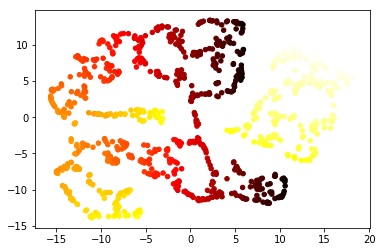

In [17]:
X, t = make_swiss_roll(n_samples=1000, noise=0, random_state=0)
Y = tsne(X, 2, 50, 20.0)
plt.scatter(Y[:, 0], Y[:, 1], 20, c = t, cmap=plt.cm.hot)
plt.show()